In [1]:
import json
import pandas as pd
import torch
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from torch import nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pathlib import Path
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


batch_size = 8
json_file = 'drive/MyDrive/yelp_dataset/review_dataset.json'

In [12]:
import torch.nn.functional as F
def split_dataset(dataset, split_ratio=0.8):
    split_idx = int(len(dataset) * split_ratio)
    return dataset[:split_idx], dataset[split_idx:]

class Classifier(nn.Module):
    def __init__(self, fan_in, hidden_dim: int = 256):
      super(Classifier, self).__init__()
      self.fc1 = nn.Linear(fan_in, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, hidden_dim)
      self.fc3 = nn.Linear(hidden_dim, 5)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)

      return x


class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.encoder = BertModel.from_pretrained('bert-base-uncased')
        # self.classifier = nn.Linear(self.encoder.config.hidden_size, 5)
        self.classifier = Classifier(self.encoder.config.hidden_size)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids, attention_mask=attention_mask)
        # take the [CLS] hidden state in the last layer
        pooled_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(pooled_output)

    def fit(self, train_data, epochs=4, batch_size=32, lr=2e-5):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        optimizer = Adam(self.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            self.train()
            total_loss = 0
            for i, batch in tqdm(enumerate(train_loader)):
                inputs = self.tokenizer(batch['text'], padding=True, truncation=True, return_tensors="pt")
                input_ids = inputs['input_ids'].to(self.device)
                attention_mask = inputs['attention_mask'].to(self.device)

                labels = batch['label'].to(torch.long).to(self.device)

                optimizer.zero_grad()
                outputs = self(input_ids, attention_mask)
                loss = loss_fn(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                if i % 50 == 0:
                    print(f"Step {i+1}, Loss {loss.item()}")

                if i > 5000 / batch_size:
                    break

            print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

    def predict_proba(self, texts):
        self.eval()
        inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = self(inputs['input_ids'].to(self.device), inputs['attention_mask'].to(self.device))
            predictions = torch.softmax(outputs, dim=1)
        return predictions

    def predict(self, texts):
        pred = self.predict_proba(texts)
        # return labels with highest probability
        return torch.argmax(pred, dim=1)

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))


class TextDataset(Dataset):
    def __init__(self, input):
         self.data = input

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['text']
        label = item['stars'] - 1   # handle off-by-1 issue
        return {"text": text, "label": label}

def load_data(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    return data


data = load_data(json_file)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = TextDataset(train_data)
test_dataset = TextDataset(test_data)

model = BERTClassifier()
model.fit(train_dataset, epochs=4, batch_size=batch_size, lr=2e-5)


1it [00:00,  1.27it/s]

Step 1, Loss 1.5774892568588257


51it [00:25,  1.65it/s]

Step 51, Loss 1.2077109813690186


101it [00:47,  1.93it/s]

Step 101, Loss 1.303163766860962


151it [01:10,  2.08it/s]

Step 151, Loss 1.104230523109436


201it [01:34,  2.96it/s]

Step 201, Loss 0.6482263803482056


252it [01:58,  2.81it/s]

Step 251, Loss 0.8688961863517761


301it [02:23,  2.07it/s]

Step 301, Loss 0.8093783855438232


351it [02:46,  2.42it/s]

Step 351, Loss 1.0660169124603271


401it [03:11,  2.18it/s]

Step 401, Loss 0.7267075777053833


451it [03:34,  1.87it/s]

Step 451, Loss 0.42507195472717285


501it [03:58,  2.24it/s]

Step 501, Loss 0.5978761315345764


551it [04:22,  2.58it/s]

Step 551, Loss 1.3813281059265137


601it [04:45,  1.86it/s]

Step 601, Loss 0.8764171600341797


626it [04:57,  2.10it/s]


Epoch 1, Loss: 0.006084232371765028


1it [00:00,  3.77it/s]

Step 1, Loss 1.2686169147491455


51it [00:26,  2.10it/s]

Step 51, Loss 1.2840324640274048


101it [00:51,  2.05it/s]

Step 101, Loss 0.8814002871513367


151it [01:12,  2.93it/s]

Step 151, Loss 0.6051443815231323


201it [01:35,  1.95it/s]

Step 201, Loss 0.6050153970718384


251it [01:59,  2.28it/s]

Step 251, Loss 1.2849408388137817


301it [02:20,  2.89it/s]

Step 301, Loss 0.3335440158843994


351it [02:43,  2.34it/s]

Step 351, Loss 0.3079416751861572


401it [03:05,  2.62it/s]

Step 401, Loss 0.7711330056190491


451it [03:27,  2.46it/s]

Step 451, Loss 0.6612251400947571


501it [03:48,  2.32it/s]

Step 501, Loss 0.7355585694313049


551it [04:14,  1.99it/s]

Step 551, Loss 0.770240843296051


601it [04:37,  2.17it/s]

Step 601, Loss 0.5575985908508301


626it [04:49,  2.16it/s]


Epoch 2, Loss: 0.004936546342340625


1it [00:00,  3.10it/s]

Step 1, Loss 0.7825957536697388


51it [00:23,  1.65it/s]

Step 51, Loss 0.6875786185264587


101it [00:46,  2.27it/s]

Step 101, Loss 0.36007022857666016


151it [01:10,  2.33it/s]

Step 151, Loss 0.9702063798904419


201it [01:33,  2.41it/s]

Step 201, Loss 0.5094495415687561


251it [01:56,  2.39it/s]

Step 251, Loss 1.0700613260269165


301it [02:21,  1.98it/s]

Step 301, Loss 0.751919686794281


351it [02:45,  2.37it/s]

Step 351, Loss 0.8011718988418579


401it [03:07,  2.24it/s]

Step 401, Loss 0.45116424560546875


451it [03:30,  1.59it/s]

Step 451, Loss 1.3157627582550049


501it [03:53,  2.65it/s]

Step 501, Loss 0.7061349153518677


551it [04:17,  1.99it/s]

Step 551, Loss 1.6355433464050293


601it [04:41,  2.03it/s]

Step 601, Loss 0.42485448718070984


626it [04:53,  2.13it/s]


Epoch 3, Loss: 0.004746009488135796


1it [00:00,  3.24it/s]

Step 1, Loss 0.593854546546936


51it [00:21,  2.15it/s]

Step 51, Loss 1.3304295539855957


101it [00:45,  2.22it/s]

Step 101, Loss 0.5143405199050903


151it [01:09,  2.33it/s]

Step 151, Loss 0.8200671672821045


201it [01:34,  1.80it/s]

Step 201, Loss 0.47333455085754395


251it [01:57,  2.69it/s]

Step 251, Loss 0.751922607421875


301it [02:22,  2.03it/s]

Step 301, Loss 0.42444750666618347


351it [02:46,  1.60it/s]

Step 351, Loss 0.8183571100234985


401it [03:10,  1.93it/s]

Step 401, Loss 0.5811375975608826


451it [03:32,  2.16it/s]

Step 451, Loss 0.5359955430030823


501it [03:56,  2.51it/s]

Step 501, Loss 0.6252022385597229


551it [04:21,  1.94it/s]

Step 551, Loss 0.7016410827636719


601it [04:47,  1.86it/s]

Step 601, Loss 0.5791871547698975


626it [04:59,  2.09it/s]

Epoch 4, Loss: 0.004626080573780292


In [ ]:
!nvidia-smi

Mon Apr 22 01:35:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              31W /  70W |   7563MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

63it [00:12,  5.24it/s]


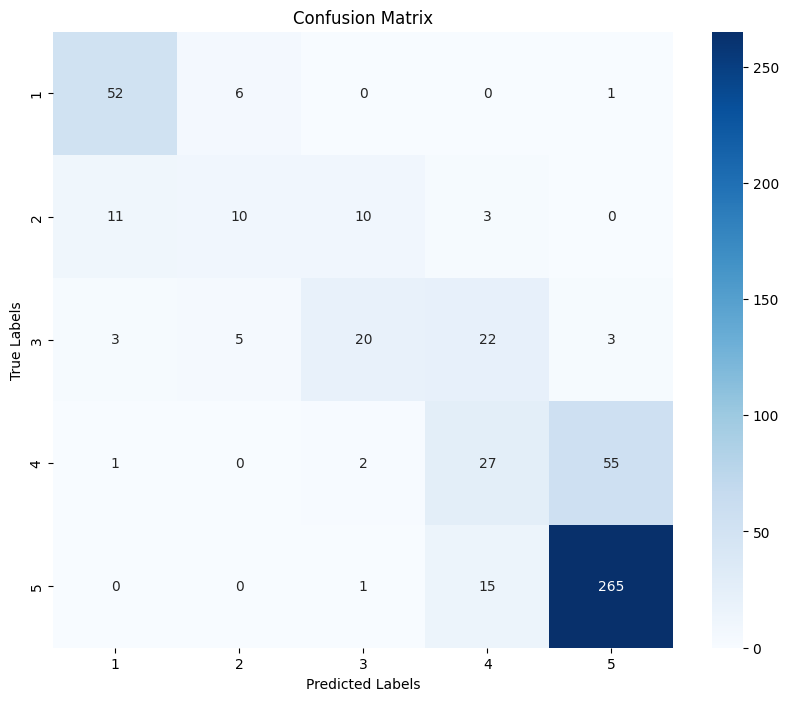

     Metric     Value
0  Accuracy  0.730469
1   ROC AUC  0.738000
              precision    recall  f1-score   support

     Class 1       0.78      0.88      0.83        59
     Class 2       0.48      0.29      0.36        34
     Class 3       0.61      0.38      0.47        53
     Class 4       0.40      0.32      0.36        85
     Class 5       0.82      0.94      0.88       281

    accuracy                           0.73       512
   macro avg       0.62      0.56      0.58       512
weighted avg       0.70      0.73      0.71       512



In [13]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
all_preds = []
all_labels = []
all_preds_prob = []
model.eval()
for i, batch in tqdm(enumerate(test_loader)):
    texts = batch['text']
    labels = batch['label'].numpy()

    inputs = model.tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(inputs['input_ids'].to(model.device), inputs['attention_mask'].to(model.device))
        predictions = torch.softmax(outputs, dim=1)
    preds = torch.argmax(predictions, dim=1).detach().cpu().numpy()
    all_preds_prob.extend(predictions.detach().cpu().numpy())
    all_preds.extend(preds)
    all_labels.extend(labels)

    if i > 500 / batch_size:
        break

all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4])
all_preds_bin = label_binarize(all_preds, classes=[0, 1, 2, 3, 4])


accuracy = accuracy_score(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
cm = confusion_matrix(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels_bin, all_preds_bin, multi_class='ovr')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

performance_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC'],
    'Value': [accuracy, roc_auc]
})
print(performance_df)

print(class_report)

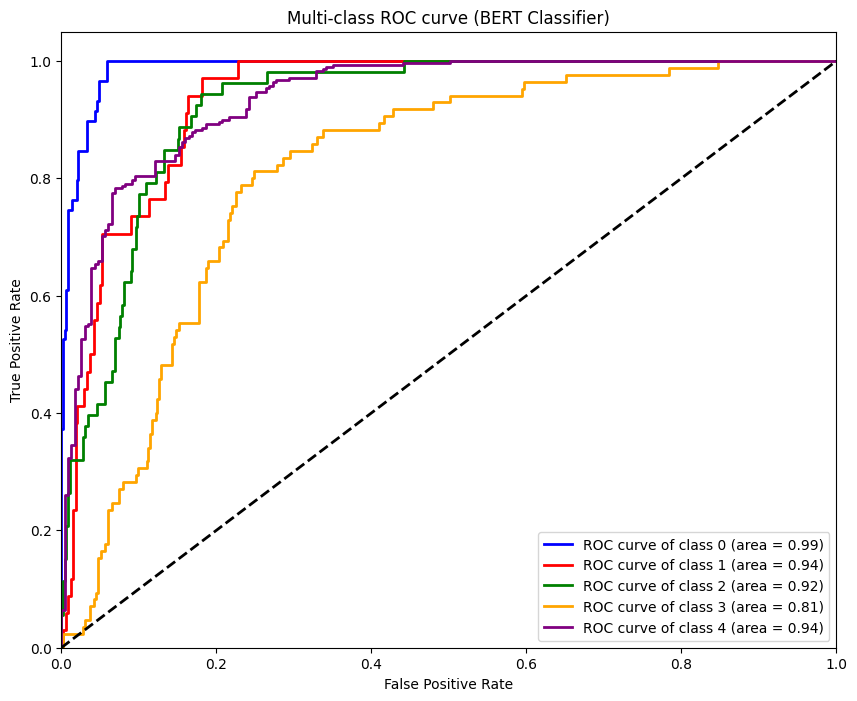

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

n_classes = 5
fpr = dict()
tpr = dict()
roc_auc = dict()
all_preds_prob = np.array(all_preds_prob)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve (BERT Classifier)')
plt.legend(loc="lower right")
plt.show()